In [46]:
import itertools
import json

import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

stopwords = set(nltk.corpus.stopwords.words('english'))
stem_func = nltk.PorterStemmer().stem

df = pd.read_csv('C:/Users/matth/Desktop/ADSProject1/data/philosophy_data.csv')
df['tokenized_txt_list'] = df['tokenized_txt'].apply(
    lambda x: [stem_func(word) for word in json.loads(x.replace("'", "\"")) if word not in stopwords])

df['century'] = (df['original_publication_date'] // 100) * 100
df.loc[df['century'] < 1600, 'century'] = -1000000
df.to_csv('../output/data_with_tokenized_txt.csv', index=False)

In [491]:
df = pd.read_csv('../output/data_with_tokenized_txt.csv')
# pd.to_csv() saves lists as strings, not lists
df['tokenized_txt_list'] = df['tokenized_txt_list'].apply(lambda x: json.loads(x.replace("'", "\"")))

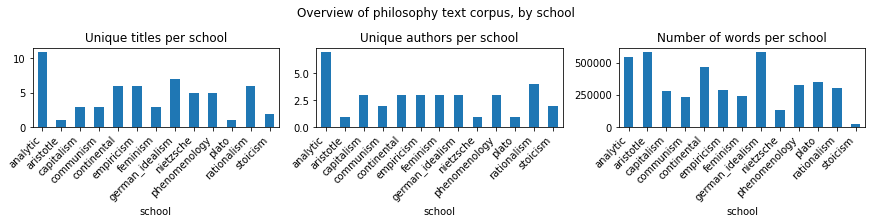

In [575]:
fig, ax = plt.subplots(nrows=1, ncols=3, constrained_layout=True, figsize=(12, 3))
group = 'school'
plt.suptitle(f'Overview of philosophy text corpus, by {group}')

df.groupby(group)['title'].nunique().plot(kind='bar', title=f'Unique titles per {group}', ax=ax[0])
df.groupby(group)['author'].nunique().plot(kind='bar', title=f'Unique authors per {group}', ax=ax[1])

words_by_group = df.groupby(group)['tokenized_txt_list'].apply(lambda x: list(itertools.chain.from_iterable(x)))
words_by_group.apply(len).plot(kind='bar', title=f'Number of words per {group}', ax=ax[2])

for i in range(len(ax)):
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45, ha='right')

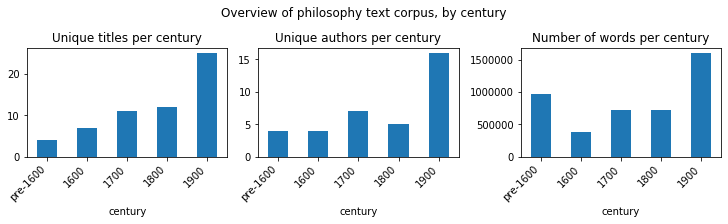

In [494]:
fig, ax = plt.subplots(nrows=1, ncols=3, constrained_layout=True, figsize=(10, 3))
group = 'century'
plt.suptitle(f'Overview of philosophy text corpus, by {group}')

df.groupby(group)['title'].nunique().plot(kind='bar', title=f'Unique titles per {group}', ax=ax[0])
df.groupby(group)['author'].nunique().plot(kind='bar', title=f'Unique authors per {group}', ax=ax[1])

words_by_group = df.groupby(group)['tokenized_txt_list'].apply(lambda x: list(itertools.chain.from_iterable(x)))
words_by_group.apply(len).plot(kind='bar', title=f'Number of words per {group}', ax=ax[2])

for i in range(len(ax)):
    ax[i].set_xticklabels(['pre-1600'] + list(ax[i].get_xticklabels()[1:]), rotation=45, ha='right')

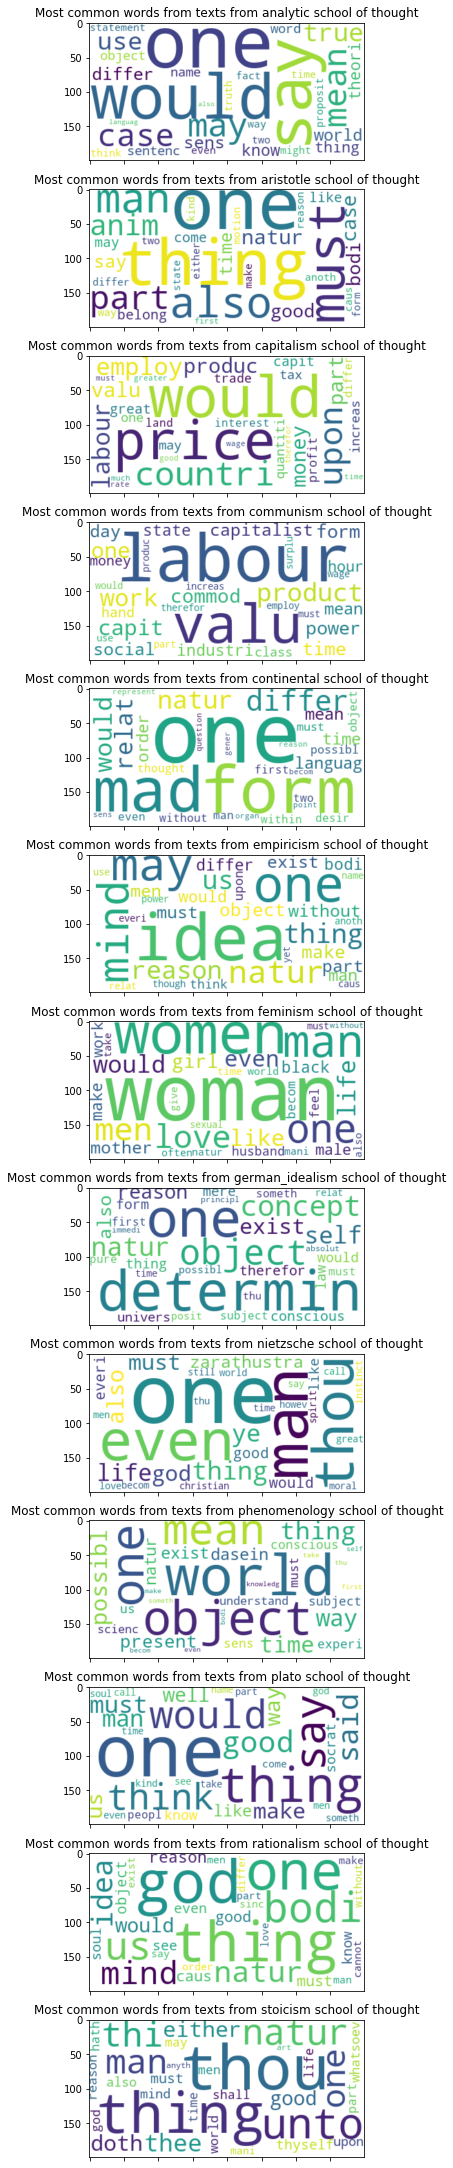

In [576]:
import wordcloud

fig, ax = plt.subplots(nrows=words_by_group.shape[0], figsize=(10, 30), constrained_layout=True)

wcs = []
for i, (group_name, words) in enumerate(words_by_group.iteritems()):
    words, counts = np.unique(words, return_counts=True)
    wc = pd.DataFrame({'word': words, 'count': counts})
    wc = wc[~wc['word'].isin(stopwords)].sort_values('count', ascending=False).iloc[:30,]
    cloud = wordcloud.WordCloud(background_color='white').fit_words(wc.set_index('word')['count'].to_dict())
    ax[i].imshow(cloud, interpolation='bilinear')
    ax[i].set_title(f'Most common words from texts from {group_name} school of thought')

for i in range(len(ax)):
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45, ha='right')

An examination of the most common words in the corpus, broken down by school, shows that the texts share certain writing patterns. All schools use the word 'one' very often, to pose theoretical points that apply to individuals. Other common words follow along this line of theoretical phrasing, including words like 'would', 'thing', 'idea', and 'must'. After these words, the word clouds begin to diverge, as each school discusses a different focus of ideas.

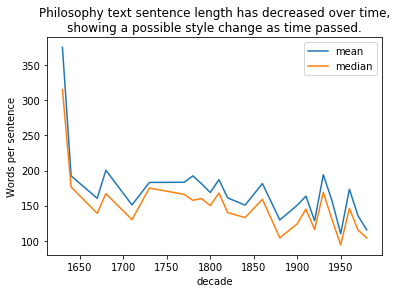

In [683]:
df['decade'] = (df['original_publication_date'] // 10) * 10
centuries = df.loc[df['original_publication_date'] >= 1600].groupby('decade')['sentence_length']
centuries.agg(['mean', 'median']).plot(
    title='Philosophy text sentence length has decreased over time,\nshowing a possible style change as time passed.', ylabel='Words per sentence')

[Text(0, 0, 'analytic'),
 Text(0, 0, 'aristotle'),
 Text(0, 0, 'capitalism'),
 Text(0, 0, 'communism'),
 Text(0, 0, 'continental'),
 Text(0, 0, 'empiricism'),
 Text(0, 0, 'feminism'),
 Text(0, 0, 'german_idealism'),
 Text(0, 0, 'nietzsche'),
 Text(0, 0, 'phenomenology'),
 Text(0, 0, 'plato'),
 Text(0, 0, 'rationalism'),
 Text(0, 0, 'stoicism')]

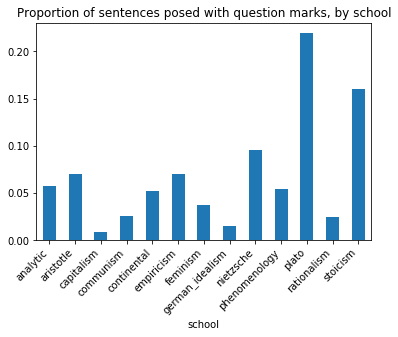

In [680]:
group = 'school'
df['question'] = df['sentence_lowered'].str.contains('\?')
q_grouped = df.groupby([group, 'question'])['sentence_lowered'].count() / df.groupby(group)['sentence_lowered'].count()
q_proportions = q_grouped[q_grouped.index.get_level_values('question') == True] \
    .reset_index().drop('question', axis='columns').rename(columns={'sentence_lowered': '% questions'})

fig, ax = plt.subplots()
q_proportions.set_index(group)['% questions'].plot(
    title=f'Proportion of sentences posed with question marks, by {group}', ax=ax, kind='bar')

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

The frequency of questions differs considerably across different schools. Plato seems to raise questions in his writing the most often.

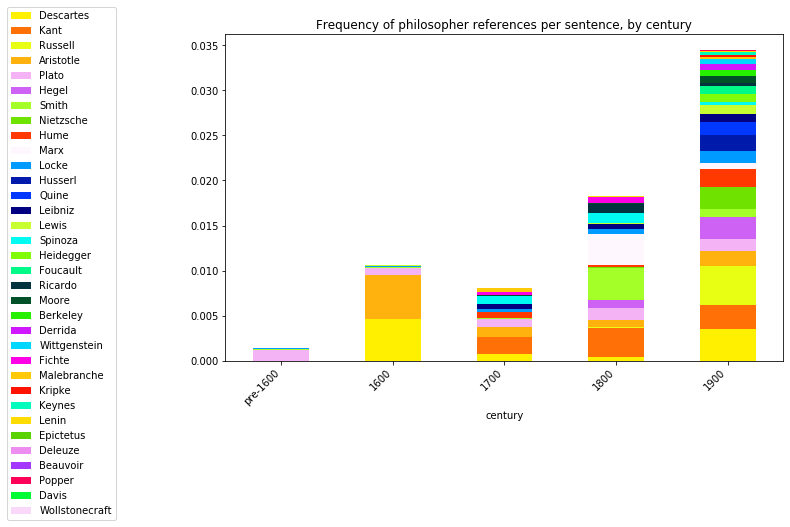

In [540]:
fix, ax = plt.subplots(figsize=(30, 10))

author_stems = {stem_func(author.lower()): author for author in df['author'].unique()}

df['refd_authors'] = df['tokenized_txt_list'].apply(lambda l: list(set(l).intersection(set(author_stems.keys()))))
refd_authors = df.loc[df['refd_authors'].str.len() > 0,
                      ['refd_authors', 'sentence_lowered', 'century', 'question', 'school']
                     ].explode('refd_authors').rename(columns={'refd_authors': 'refd_author'})
refd_authors['refd_author'] = refd_authors['refd_author'].apply(author_stems.get)
author_freq_order = refd_authors.groupby(['refd_author'])['refd_author'].count().sort_values(ascending=False).index.to_list()
colors = [plt.get_cmap('gist_ncar')(x) for x in np.linspace(0, 1, len(author_freq_order))]
random.shuffle(colors)
refd_authors_freq = refd_authors.groupby(['century', 'refd_author']).count()['sentence_lowered'] / df.groupby('century')['sentence_lowered'].count()
refd_authors_freq.rename('referenced_authors').unstack()[author_freq_order].plot(
    kind='bar', stacked=True, figsize=(10, 6), title='Frequency of philosopher references per sentence, by century', color=colors, ax=ax)
ax.set_xticklabels(['pre-1600'] + list(ax.get_xticklabels()[1:]), rotation=45, ha='right')
ax.legend(bbox_to_anchor=(-.4, 1.1), loc='upper left', ncol=1)

The proportion of sentences that mention another philosopher has increased over time. Descartes, Kant, Aristotle, and Plato seem to have had consistent influence over these writings across multiple centuries. Plato's incredible tendency to question illuminates a reason why he had so much influence on future philosophers.

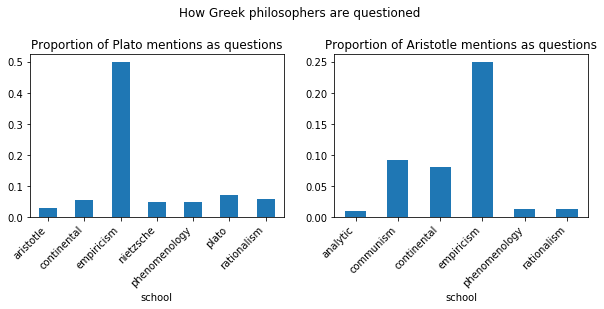

In [664]:
group = 'school'

significant_authors = ['Plato', 'Aristotle']
fig, ax = plt.subplots(ncols=len(significant_authors), figsize=(10, 3))
plt.suptitle('How Greek philosophers are questioned', y=1.1)
for i, author in enumerate(significant_authors):
    plato_questions = refd_authors.loc[refd_authors['refd_author'] == author].groupby([group, 'question']).count()
    plato_by_century = plato_questions['sentence_lowered'].groupby(level=0).transform(lambda x: x / x.sum())
    plato_by_century[plato_by_century.index.get_level_values(1)].droplevel(1).plot(
        kind='bar', title=f'Proportion of {author} mentions as questions', ax=ax[i])
    
for i in range(len(ax)):
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45, ha='right')

Greek philosophy has had a profound effect on the texts in this corpus. Writers from the empiricism school seem to raise questions on Greek philosophy most often.